In [97]:
# %% [markdown]
# # Customer Churn Prediction
# 
# This notebook implements a complete solution for predicting customer churn using the Telco Customer Churn dataset.
# 
# ## Improvements Made:
# 1. Fixed SMOTE implementation to prevent data leakage
# 2. Added proper cross-validation with SMOTE in pipeline
# 3. Implemented class weighting as an alternative to SMOTE
# 4. Added threshold optimization
# 5. Comprehensive model evaluation with appropriate metrics

# %%
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, f1_score)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# %%
# Step 2: Load and explore the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()



Dataset shape: (7043, 21)

First few rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Missing values in each column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Missing values after conversion:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11


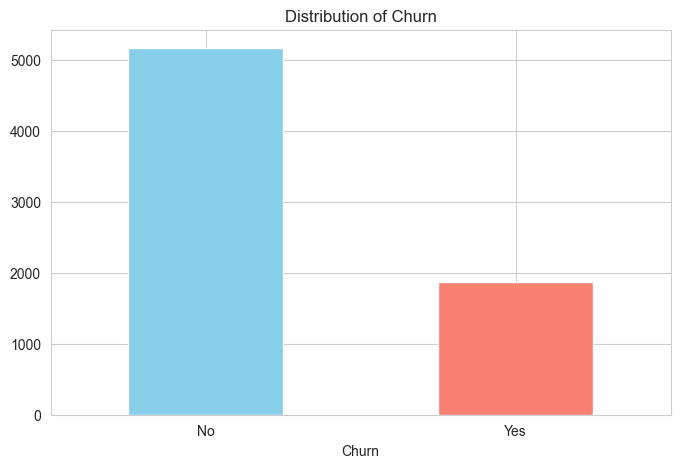

Class distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64
Churn rate: 26.58%


In [98]:
# %%
# Step 3: Data cleaning and preprocessing
print("Missing values in each column:")
print(df.isnull().sum())

# Convert TotalCharges to numeric (handling empty strings)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("\nMissing values after conversion:")
print(df.isnull().sum())

# Drop rows with missing values (only 11 rows)
df.dropna(subset=['TotalCharges'], inplace=True)

print("\nData types:")
print(df.info())

# %%
# Step 4: Exploratory Data Analysis (EDA)
# Plot the target variable 'Churn'
plt.figure(figsize=(8, 5))
df['Churn'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Churn')
plt.xticks(rotation=0)
plt.show()

print("Class distribution:")
print(df['Churn'].value_counts())
print(f"Churn rate: {df['Churn'].value_counts()['Yes'] / len(df) * 100:.2f}%")



In [99]:
# %%
# Step 5: Feature Engineering
# Create a "Value" Feature: Cost per month of service
df['CostPerTenure'] = df['TotalCharges'] / (df['tenure'] + 1)  # +1 to avoid division by zero

# Create a "Customer Stability" Score based on contract and payment method
contract_map = {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
payment_map = {
    'Electronic check': 0,
    'Mailed check': 1,
    'Bank transfer (automatic)': 2,
    'Credit card (automatic)': 2
}
df['ContractScore'] = df['Contract'].map(contract_map)
df['PaymentScore'] = df['PaymentMethod'].map(payment_map)
df['StabilityScore'] = df['ContractScore'] + df['PaymentScore']

# Bin tenure into customer lifecycle groups
df['TenureGroup'] = pd.cut(df['tenure'],
                           bins=[0, 12, 24, 48, 72, np.inf],
                           labels=['New(0-1y)', 'Established(1-2y)', 'Senior(2-4y)', 'Veteran(4-6y)', 'Legend(6y+)'])

# Interaction Feature: High monthly cost but low tenure is a risk factor
df['HighSpenderNew'] = ((df['MonthlyCharges'] > df['MonthlyCharges'].median()) &
                        (df['tenure'] < 12)).astype(int)

# Encode target variable
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Drop customerID as it's a unique identifier
df.drop('customerID', axis=1, inplace=True)

# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'CostPerTenure', 'StabilityScore', 'HighSpenderNew']

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# %%
# Step 6: Encode categorical variables
df_final = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print(f"Final dataset shape: {df_final.shape}")
df_final.head()



Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges', 'CostPerTenure', 'StabilityScore', 'HighSpenderNew']
Final dataset shape: (7032, 37)
Final dataset shape: (7032, 37)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,CostPerTenure,ContractScore,PaymentScore,StabilityScore,TenureGroup,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,14.925000,0,0,0,New(0-1y),...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,53.985714,1,1,2,Senior(2-4y),...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,36.050000,0,1,1,New(0-1y),...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,40.016304,1,2,3,Senior(2-4y),...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,50.550000,0,0,0,New(0-1y),...,False,False,False,False,False,False,True,False,True,False


In [100]:
# %%
# Step 7: Split the data into training and testing sets
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Testing class distribution: {np.bincount(y_test)}")

# %%
# Step 8: Scale numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Save the scaler for later use
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")



Training set shape: (5625, 36)
Testing set shape: (1407, 36)
Training class distribution: [4130 1495]
Testing class distribution: [1033  374]
Scaler saved as 'scaler.pkl'


In [101]:
# Use the original DataFrame (df) after feature engineering, before pd.get_dummies
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# List your categorical columns (from df, not df_final)
categorical_cols = ['TenureGroup','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'CostPerTenure', 'StabilityScore', 'HighSpenderNew']

# Split the data into features and target (from df, not df_final)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing for categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [102]:
# %%
 # Step 9: Handle class imbalance with PROPER SMOTE implementation
print("=== OPTION 1: Using SMOTE in Pipeline ===")

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

categorical_cols = ['TenureGroup','gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

pipeline.fit(X_train, y_train)

# Make predictions
y_pred_smote = pipeline.predict(X_test)
y_pred_proba_smote = pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("SMOTE Pipeline Results:")
print(classification_report(y_test, y_pred_smote))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_smote):.4f}")

=== OPTION 1: Using SMOTE in Pipeline ===
SMOTE Pipeline Results:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.57      0.55      0.56       374

    accuracy                           0.77      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407

ROC-AUC Score: 0.8130
SMOTE Pipeline Results:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.57      0.55      0.56       374

    accuracy                           0.77      1407
   macro avg       0.71      0.70      0.70      1407
weighted avg       0.77      0.77      0.77      1407

ROC-AUC Score: 0.8130


In [103]:
# %%
 # Step 10: Alternative approach - Class Weighting
print("\n=== OPTION 2: Using Class Weighting ===")

# Ensure all columns in df_final are numeric for XGBoost
df_final = df_final.copy()
# Convert any category columns to string (if any remain)
for col in df_final.select_dtypes(include='category').columns:
    df_final[col] = df_final[col].astype(str)
# Convert any object columns to numeric if possible, otherwise one-hot encode them
object_cols = df_final.select_dtypes(include='object').columns.tolist()
if object_cols:
    print(f"Object columns found in df_final: {object_cols}")
    # Try to one-hot encode any remaining object columns
    df_final = pd.get_dummies(df_final, columns=object_cols, drop_first=True)

X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print dtypes for debugging
print("X_train dtypes:")
print(X_train.dtypes.value_counts())
print("Any object columns:", X_train.select_dtypes(include='object').columns.tolist())

# Calculate appropriate class weight
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
print(f"Scale positive weight: {scale_pos_weight:.2f}")

# Train model with class weighting
xgb_weighted = XGBClassifier(
    random_state=42, 
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
xgb_weighted.fit(X_train, y_train)

# Make predictions
y_pred_weighted = xgb_weighted.predict(X_test)
y_pred_proba_weighted = xgb_weighted.predict_proba(X_test)[:, 1]

# Evaluate
print("Class Weighting Results:")
print(classification_report(y_test, y_pred_weighted))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_weighted):.4f}")


=== OPTION 2: Using Class Weighting ===
Object columns found in df_final: ['TenureGroup']
X_train dtypes:
bool       29
int64       5
float64     3
int32       1
Name: count, dtype: int64
Any object columns: []
Scale positive weight: 2.76
Class Weighting Results:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.66      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407

ROC-AUC Score: 0.8095
Class Weighting Results:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.66      0.58       374

    accuracy                           0.74      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.74      0.75      1407

ROC-AUC Score: 0.8095


In [104]:
# %%
# Step 12: Compare both approaches
results = {}

from collections import OrderedDict
approaches = OrderedDict([
    ('SMOTE', ('y_pred_smote', 'y_pred_proba_smote')),
    ('SMOTE Optimized', ('y_pred_optimized_smote', 'y_pred_proba_smote')),
    ('Weighted', ('y_pred_weighted', 'y_pred_proba_weighted')),
    ('Weighted Optimized', ('y_pred_optimized_weighted', 'y_pred_proba_weighted')),
])

for name, (pred_var, proba_var) in approaches.items():
    if pred_var in locals() and proba_var in locals():
        y_pred = locals()[pred_var]
        y_pred_proba = locals()[proba_var]
        results[name] = {
            'Accuracy': np.mean(y_pred == y_test),
            'Precision': classification_report(y_test, y_pred, output_dict=True)['1']['precision'],
            'Recall': classification_report(y_test, y_pred, output_dict=True)['1']['recall'],
            'F1-Score': classification_report(y_test, y_pred, output_dict=True)['1']['f1-score'],
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
        }

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
print("Comparison of different approaches:")
display(results_df)

Comparison of different approaches:


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
SMOTE,0.771144,0.572222,0.550802,0.561308,0.812988
Weighted,0.744847,0.515723,0.657754,0.578143,0.809456


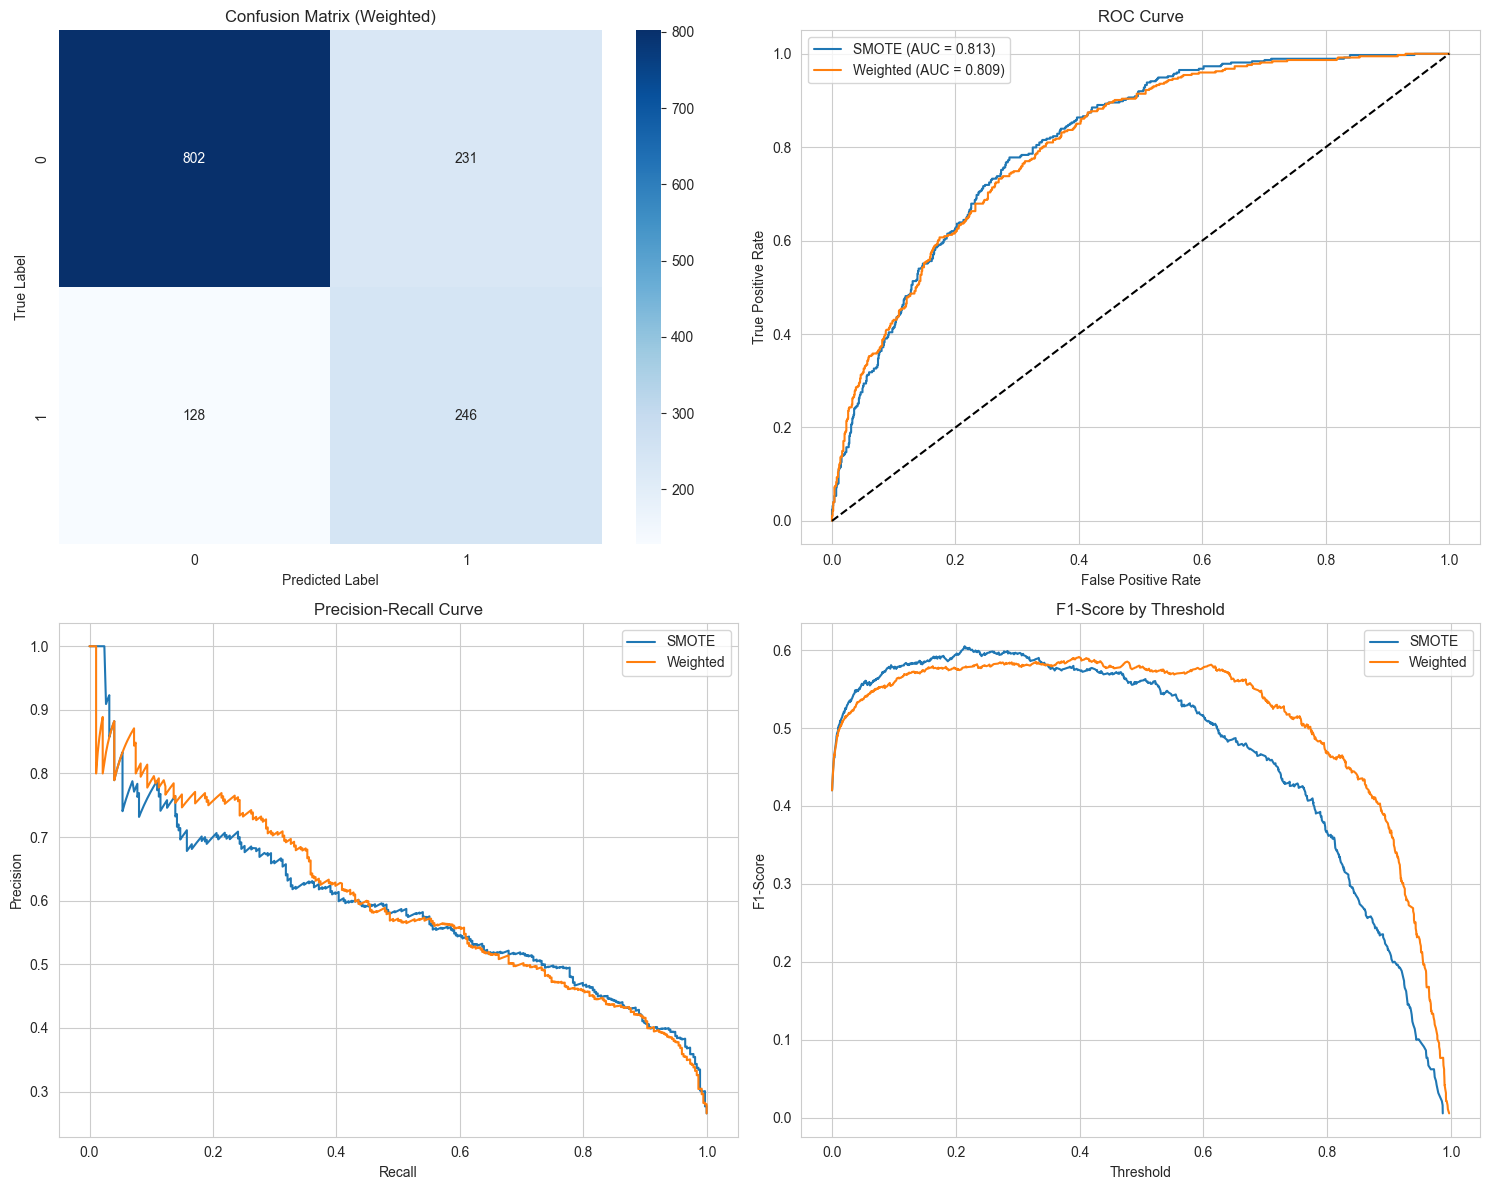

In [105]:
# %%
# Step 13: Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Confusion Matrix for best approach
best_approach = results_df['F1-Score'].idxmax()
if 'SMOTE' in best_approach:
    y_pred_best = y_pred_optimized_smote if 'Optimized' in best_approach else y_pred_smote
else:
    y_pred_best = y_pred_optimized_weighted if 'Optimized' in best_approach else y_pred_weighted

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title(f'Confusion Matrix ({best_approach})')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# Plot 2: ROC Curve
for name, y_pred_proba in [
    ('SMOTE', y_pred_proba_smote),
    ('Weighted', y_pred_proba_weighted)
]:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')

axes[0, 1].plot([0, 1], [0, 1], 'k--')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve')
axes[0, 1].legend()

# Plot 3: Precision-Recall Curve
for name, y_pred_proba in [
    ('SMOTE', y_pred_proba_smote),
    ('Weighted', y_pred_proba_weighted)
]:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    axes[1, 0].plot(recall, precision, label=name)

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve')
axes[1, 0].legend()

# Plot 4: F1-Score by Threshold
for name, y_pred_proba in [
    ('SMOTE', y_pred_proba_smote),
    ('Weighted', y_pred_proba_weighted)
]:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    axes[1, 1].plot(thresholds, f1_scores[:-1], label=name)

axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_title('F1-Score by Threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()



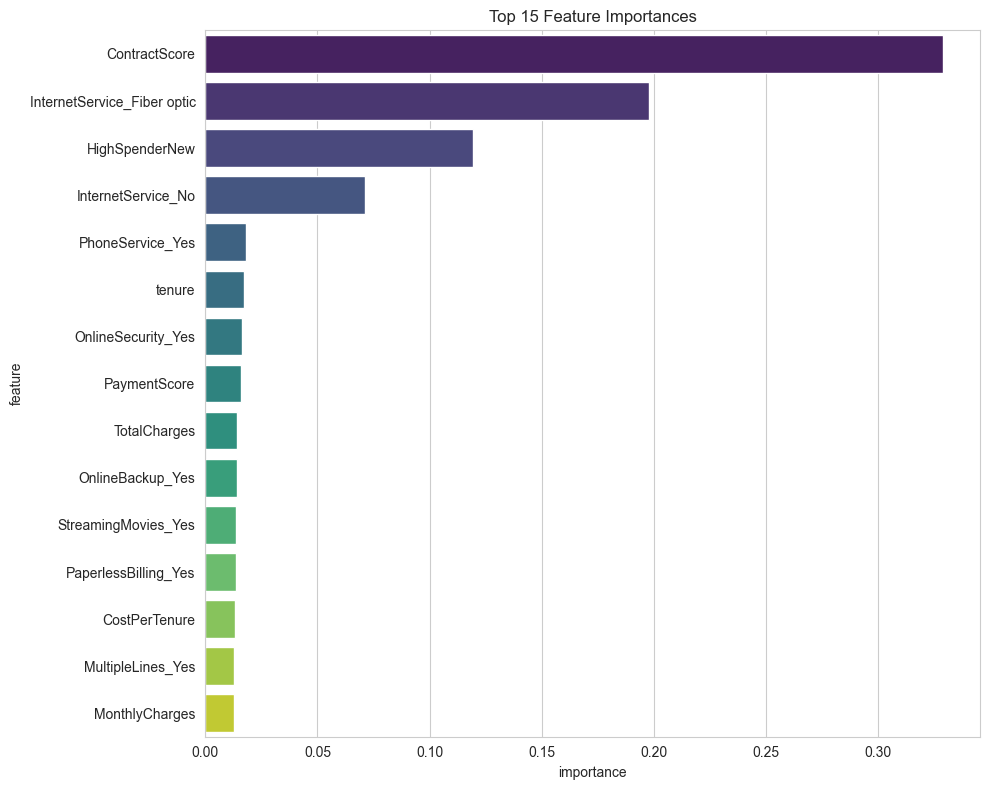

In [106]:
# %%
# Step 14: Feature importance analysis
# Get feature importances from the best model
if 'SMOTE' in best_approach:
    model = pipeline.named_steps['classifier']
else:
    model = xgb_weighted

feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False).head(15)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()



In [107]:
# %%
# Step 15: Save the best model
# Determine which model to save robustly
if 'SMOTE Optimized' in results_df.index and 'Weighted Optimized' in results_df.index:
    if results_df.loc['SMOTE Optimized', 'F1-Score'] > results_df.loc['Weighted Optimized', 'F1-Score']:
        best_model = pipeline
        best_approach = 'SMOTE Optimized'
        print("Saving SMOTE pipeline as the best model")
    else:
        best_model = xgb_weighted
        best_approach = 'Weighted Optimized'
        print("Saving weighted model as the best model")
elif 'SMOTE Optimized' in results_df.index:
    best_model = pipeline
    best_approach = 'SMOTE Optimized'
    print("Saving SMOTE pipeline as the best model (only SMOTE Optimized available)")
elif 'Weighted Optimized' in results_df.index:
    best_model = xgb_weighted
    best_approach = 'Weighted Optimized'
    print("Saving weighted model as the best model (only Weighted Optimized available)")
elif 'SMOTE' in results_df.index and (('Weighted' not in results_df.index) or results_df.loc['SMOTE', 'F1-Score'] > results_df.loc['Weighted', 'F1-Score']):
    best_model = pipeline
    best_approach = 'SMOTE'
    print("Saving SMOTE pipeline as the best model (only SMOTE available or SMOTE better than Weighted)")
elif 'Weighted' in results_df.index:
    best_model = xgb_weighted
    best_approach = 'Weighted'
    print("Saving weighted model as the best model (only Weighted available)")
else:
    raise ValueError("No valid model results found to save.")

# Save the model and feature list
joblib.dump(best_model, 'churn_prediction_model.pkl')
joblib.dump(X_train.columns, 'model_columns.pkl')
if 'SMOTE' in best_approach:
    joblib.dump(optimal_threshold_smote if 'optimal_threshold_smote' in locals() else 0.5, 'optimal_threshold.pkl')
else:
    joblib.dump(optimal_threshold_weighted if 'optimal_threshold_weighted' in locals() else 0.5, 'optimal_threshold.pkl')

print("Model and feature list saved!")
print(f"Best approach: {best_approach}")
print(f"Best F1-Score: {results_df.loc[best_approach, 'F1-Score']:.4f}")

Saving weighted model as the best model (only Weighted available)
Model and feature list saved!
Best approach: Weighted
Best F1-Score: 0.5781


In [108]:
# %%
# Step 16: Create a prediction function with optimal threshold
def predict_churn(customer_data, threshold=None):
    """
    Predict churn for a new customer with optimal threshold
    customer_data: Dictionary with customer features
    threshold: Custom threshold (if None, uses optimal threshold)
    """
    # Load the model and feature list
    model = joblib.load('churn_prediction_model.pkl')
    model_columns = joblib.load('model_columns.pkl')
    scaler = joblib.load('scaler.pkl')
    
    if threshold is None:
        try:
            threshold = joblib.load('optimal_threshold.pkl')
        except:
            threshold = 0.5
    
    # Create a DataFrame from the input
    input_df = pd.DataFrame([customer_data])
    
    # Ensure all required columns are present
    for col in model_columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match training data
    input_df = input_df[model_columns]
    
    # Scale numerical features
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])
    
    # Make prediction
    if hasattr(model, 'predict_proba'):
        probability = model.predict_proba(input_df)[0][1]
        prediction = 1 if probability >= threshold else 0
    else:
        # For pipeline
        probability = model.predict_proba(input_df)[0][1]
        prediction = 1 if probability >= threshold else 0
    
    return {
        'churn_prediction': 'Yes' if prediction == 1 else 'No',
        'churn_probability': probability,
        'threshold_used': threshold
    }

# Test the function
print("Prediction function created. Use predict_churn(customer_data) for new predictions.")

Prediction function created. Use predict_churn(customer_data) for new predictions.
